## Walkthrough of RANSAC implmentation with two examples

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import ransac

Let's assume we have a set of 2D points, where 50% of points follow a linear trend (but are noisy) and the other 50% of points are random. Instead of fitting a line with least squares, we will try to find the trend using the provided implementation of RANSAC.  

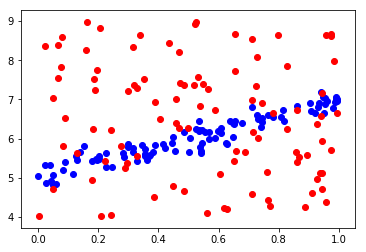

In [42]:
# create noisy 2D test points along a line
def f(x, sigma):
    return 2*x + 5 + np.random.randn(x.shape[0])*sigma

N = 100 # number of points alone line
sigma = 0.2 # noise standard deviation
x = np.random.rand(N)
y = f(x, sigma)

# add some outliers / random points to x and y
N_rand = 100
x_out = np.random.rand(N_rand)
y_out = np.random.rand(N_rand)*5 + 4

x = np.append(x, x_out)
y = np.append(y, y_out)

# plot the good points in blue and the noise in red
plt.scatter(x[:N], y[:N], color='b')
plt.scatter(x[N:], y[N:], color='r')

Because estimation of a line is not provided in the RANSAC implementation, we need to define a function that returns the best estimate of a line, given a set of two or more points in 2D. 

In [43]:
# estimate linear function in 2D given at least two points with coordinates x and y
def linEst(pts):
    x = pts[0, :]
    y = pts[1, :]
    N = x.shape[0]
    assert N > 1
    sx = np.sum(x)
    sy = np.sum(y)
    m = (N * np.sum(x*y) - sx*sy) / (N * np.sum(x**2) - sx**2)
    b = (sy - m*sx) / N
    
    # return slope m and y-intercept b
    return m, b

Next, we need to write a function that calculates the distance of a set of points to a line as returned by the estimation function. This function will be used to check which points are "inliers" (i.e., close enough to the line) for a given sampled line. 

In [44]:
def calcDistPointLine(pt, line):
    m = line[0]
    b = line[1]
    x = pt[0]
    y = pt[1]
    return abs(m*x-y+b) / np.sqrt(m**2+1)

Before we can run RANSAC to find the best estimate, we need to define a couple of parameters. 

In [45]:
### RANSAC parameters ###

# Number of points that are sampled to make a prediction (here we need at least two, but three works a bit better)
minPoints = 3

# define the estimation function (we're using our definition from above)
estFunc = linEst

# number of iteration that RANSAC runs until it returns the best estimate it found
numIter = 1000

# distance threshold. All points that are within this distance of the line will be treated as "inliers"
# here, we'll chose the treshold equal to the noise standard deviation. Usually we don't have that information
# and need to make a good guess. 
thresh = 0.2

# define the distance function that is used. We are using the Euclidian Norm, but any other distance metric
# would work. The choice depends on the problem. 
distFunc = calcDistPointLine

Ready to run RANSAC. This is an example that doesn't make use of the implementation in ransac.py, but it works similarly. 

In [46]:
# RANSAC
N = x.shape[0]
maxInlr = 0
for i in range(numIter):
    # sample minimum number of points
    idx = random.sample(range(N), 3)
    pts1 = np.asarray([x[idx], y[idx]])
    pts2 = np.asarray([x, y])
    
    # estimate function
    res = linEst(pts1)
    
    # get distances to function of every point in pts2
    d = calcDistPointLine(pts2, res)
    
    # get number of inliers
    numInlr = np.sum(d < thresh)
    
    if numInlr > maxInlr:
        maxInlr = numInlr
         
        # refine by using all inliers
        idx_ref = d < thresh
        pts_ref = np.asarray([x[idx_ref], y[idx_ref]])
        resRef = linEst(pts_ref)
        
        dRefined = calcDistPointLine(pts2, resRef)
        inlierMask = dRefined < thresh
        maxInlrRef = np.sum(inlierMask)

Let's print out some stats:

In [47]:
print("Best Estimate for slope m and y-intercept b: ", resRef)
print("Number of inliers for the best estimate: ", maxInlr)

Best Estimate for slope m and y-intercept b:  (2.013079952643762, 4.999137342499584)
Number of inliers for the best estimate:  118


Let's plot the result that RANSAC found. Inliers are marked in blue, outliers in red. 

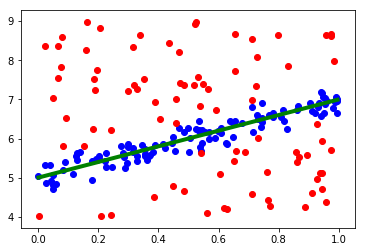

In [51]:
plt.scatter(x[inlierMask], y[inlierMask], color='b')
plt.scatter(x[np.logical_not(inlierMask)], y[np.logical_not(inlierMask)], color='r')

# also print the true line in green
x_line = np.asarray([min(x), max(x)])
plt.plot(x_line, f(x_line, 0), color='g', linewidth=4)

## This simple test of RANSAC succeeded. Now implement 3D rigid transform estimation

We have two sets of 3D points (N, 3) that we need to register via a 3D rigid transform. Given a set of three or more point pairs, there is a least squares solution to the estimation of the rigid body transform. 

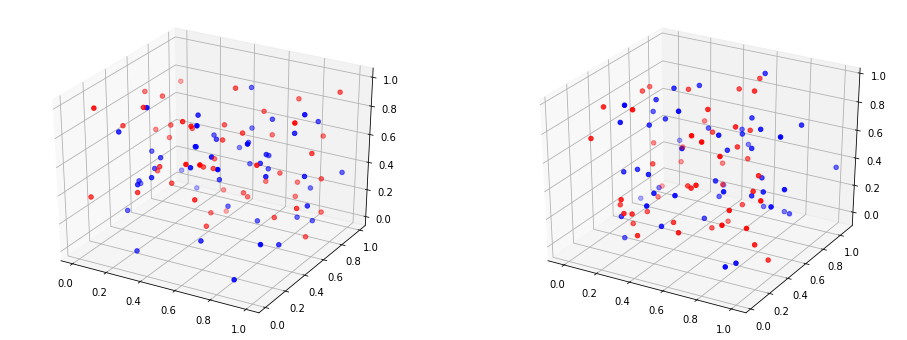

In [64]:
# create some data points to test algorithm
N = 50
pts1 = np.random.rand(N, 3)
R = np.asarray([[0, 1, 0], [1, 0, 0], [0, 0, 1]]) # simple rotation matrix
pts2 = pts1.dot(R)

# add noise to pts2
pts2 = pts2 + np.random.randn(N, 3) * 0.05

# add outliers to both sets. They're differet in both point sets of course. 
N_rand = 50
pts1_out = np.random.rand(N_rand, 3)
pts2_out = np.random.rand(N_rand, 3)

pts1 = np.append(pts1, pts1_out, axis=0)
pts2 = np.append(pts2, pts2_out, axis=0)

# plot the points in 3D
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pts1[:N, 0], pts1[:N, 1], pts1[:N, 2], c='b')
ax.scatter(pts1[N:, 0], pts1[N:, 1], pts1[N:, 2], c='r')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(pts2[:N, 0], pts2[:N, 1], pts2[:N, 2], c='b')
ax2.scatter(pts2[N:, 0], pts2[N:, 1], pts2[N:, 2], c='r')
plt.show()

The blue points in the two plots are the same, except that they are rotated by 90 degrees. The red points are random in both plots. We are trying to find the transform, that transforms the blue points in the right plot to match the blue points in the left plot, without knowing which of the points are blue and which ones are red. 

In [86]:
minPoints = 3
numIter = 1000
thresh = 0.15

# run ransac. Use the ``findRigidBody`` function
TF, mask = ransac.findRigidBody(pts1, pts2, minPoints, numIter, thresh)

In [87]:
print("The found transformation matrix is (for homogenous coordinates): \n", TF)
print("Ransac found ", np.sum(mask), "inliers")

# Let's try to get an idea of the error, using our knowledge about the correct transformation matrix: 
TF_truth = np.eye(4)
TF_truth[0:3, 0:3] = R

error = np.linalg.norm(TF_truth-TF, ord='fro')
print("The Frobenius norm of the error in the transformation matrix is: {:.2f}".format(error))

The found transformation matrix is (for homogenous coordinates): 
 [[-0.00884036  0.99992289  0.00872179  0.        ]
 [ 0.99985502  0.00871215  0.01462994  0.        ]
 [-0.01455282 -0.00884986  0.99985494  0.        ]
 [-0.00266075  0.01216795 -0.02131581  1.        ]]
Ransac found  48 inliers
The Frobenius norm of the error in the transformation matrix is: 0.04
